In [2]:
import numpy as np
import random
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

The following is a summary of a research paper:
 
Beveridge, Andrew, and Stan Wagon. “The Sorting Hat Goes to college.” Mathematics Magazine, vol. 87, no. 4, Oct. 2014, pp. 243–251, https://doi.org/10.4169/math.mag.87.4.243. 

## Problem 

Assign first-years students to their desired courses (about 500 students must be placed into about 35 first-year courses). Maximize overall student satisfaction such that each student is assigned into a course that they ranked. 

## Solution

### Integer Programming problem

**Parameters:**
- students $S_i, 1 \leq i \leq n$
- courses $C_j, 1 \leq j \leq m$
- M, F, I are indices corresponding to male, female, and international students
- preferences $P_i$
- $X_j$ : set of students i having $C_j$ as one of their choices, where $j \in P_i$
 
\* worst case $X_j = \emptyset$, where there are no students who have a preference of course j.



**Decision Variables**

$x_{i,j}$ = 1 if for each pair $(S_i, C_j)$ where $j \in P_i$, $S_i$ is assigned to $C_j$, and 0 otherwise

where $x_{i,j} \in \{0,1\}$

**Objective Function**
$$\text{min } \sum_{i=1}^n x_{i,j_{i,1}} + \alpha x_{i,j_{i,2}} + \alpha^2 x_{i,j_{i,3}}  + \alpha^3 x_{i,j_{i,4}}$$ 
where $j_{i,1}, ..., j_{i,4}$ are student $S_i$'s four preferences and $\alpha > 1$ 

* $\alpha$ is a value chosen according to the trade-offs for swapping students between classes
The weight of placing a student in a course increases as it is further from the first choice.


**Student constraint**

$\sum_{j \in P_i} x_{i,j}$ = 1 for each $i \leq n$

**Course size constraint**

The sum of the number of students enrolled in each course $C_j$ ranges from L to U:
- $L \leq \sum_{i \in X_j} x_{i,j} \leq U$ for each $j \leq m$

Typically, we have $(L, U) = (12, 16)$ so the course can have 12 to 16 students. However, it is common to have a course that allows more than 16 or less than 12. We introduce $q_{j,s}$ where s is the size of $C_j$ and $9 \leq s \leq 17$. Suppose we have $Q_{17}, Q_{11}, Q_{10}, Q_9$ that represents the maximum number of courses allowed with 17, 11, 10, and 9 respectively. Then, the ideal size of each $C_j$ for $Q_{17}, Q_{11}, Q_{10}, Q_9$ are:
* $\sum_j q_{j,17} \leq Q_{17}$ 
* $\sum_j q_{j,11} \leq Q_{11}$ 
* $\sum_j q_{j,10} \leq Q_{10}$ 
* $\sum_j q_{j,9} \leq Q_{9}$ 

However, we need to make sure that each course only takes a unique maximum number of students ranging from 9 to 17:
$$\sum_{s=9}^{17} q_{j,s} = 1 \quad \forall j$$

Therefore, we have the total number of students enrolled in $C_j$ be equal to the maximum number of students a course can have by multiplying s with $\sum_{s=9}^{17} q_{j,s}$
$$\sum_{i \in X_j} x_{i,j} = \sum_{s=9}^{17} sq_{j,s} \quad \forall j$$ 


**Gender constraint**

There are at least 4 male and 4 female in each course

* $\sum_{i \in M \cap X_j} x_{i,j} \geq 4$
* $\sum_{i \in F \cap X_j} x_{i,j} \geq 4$

The same idea from the course size constraint can be used for the gender constraint to help loosened the constraint of having at least 4 male and female.

The paper introduced a new variable $y_{m,j} = 1$ when $C_j$ has a value of m males, and 0 otherwise. So, we can make sure that $C_j$ has a maximum of m number of males:
$$\sum_{m=0}^{17} y_{m,j} = 1 \quad \forall j$$
and thus, the total number of male students enrolled in $C_j$ can be equal to the maximum number of male students a course can have by multiplying m with $\sum_{m=0}^{17} y_{m,j}$:
$$\sum_{i \in M \cap X_j} x_{i,j} = \sum_{m=0}^{17} my_{m,j} \quad \forall j$$

Similarly, we will have the same formula for the number of females in a course:
$$\sum_{i \in F \cap X_j} x_{i,j} = \sum_{f=0}^{17} fy_{f,j} \quad \forall j$$

**International constraint**

Each course contains at most B international students

$\sum_{i \in I \cap X_j} x_{i,j} \leq B \quad \forall j$



## Building Solution

#### Writing the objective function

Trying to assign each students with their first choice of preference:

In [3]:
### try obvious dataset where the student will be assigned to their first choice
# [0,1,1,0,1,2,3] means student id 0, female, international student with preference of course 0,1,2,3 from first to last choice
s = np.array([[0, 1, 1, 0, 1, 2, 4],
               [1, 1, 0, 0, 1, 2, 4],
               [2, 0, 1, 1, 0, 2, 3],
               [3, 1, 1, 1, 0, 2, 3],
                [4, 1, 0, 2, 1, 0, 3],
                [5, 1, 1, 2, 1, 0, 3],
                [6, 1, 1, 3, 1, 2, 4],
                [7, 1, 1, 3, 1, 2, 4],
                [8, 1, 1, 4, 1, 2, 0],
                [9, 1, 1, 4, 1, 2, 0]])

P = s[:,-4:] # preference P of student i

# [0,5] means course id 0 with maximum 2 students in the class
c = np.array([[0,2],[1,2],[2,2],[3,2],[4,2]])

a = 2
n = len(s)
m = len(c)
x = cp.Variable((n, m), integer = True) # set a variable that can only have integer values

# temporary constraints to check objectives
constraints = []

# each student gets exactly one course j in preference of student i
for i in range(n):
    for j in range(m):
        constraints += [cp.sum([x[i, j] for j in P[i, :]]) == 1]

# each course cannot exceed the maximum capacity of students
for j in range(m):
    constraints += [cp.sum(x[:, j]) <= c[:,1]]

constraints += [x >= 0]


# objective function
# P[i,1] is getting the first column which is getting the first-ranked choice of each student
objective = cp.Minimize(cp.sum([cp.sum([x[i, P[i,0]]  + a*x[i, P[i,1]] + a**2*x[i,P[i,2]] + a**3*x[i,P[i,3]]for i in range(n)])]))

prob = cp.Problem(objective, constraints)
print(prob.solve())

10.0


In [4]:
# show the result
for i in range(n):
    for j in range(m):
        if x.value[i][j] == 1:
            print("Student", i, "is assigned to", j)

Student 0 is assigned to 0
Student 1 is assigned to 0
Student 2 is assigned to 1
Student 3 is assigned to 1
Student 4 is assigned to 2
Student 5 is assigned to 2
Student 6 is assigned to 3
Student 7 is assigned to 3
Student 8 is assigned to 4
Student 9 is assigned to 4


### Defining the dataset for 150 students and 12 courses (in progress)

we have to create a dummy set for 150 students and 12 courses. The students will need to be classfied into male, female and international students. We need a separate array to define preferences of the students by creating an ordered list of courses. Each courses also need the limitation for the number of students. 

In [126]:
n = 140 # number of students
m = 12 # number of courses

#### Create Dataset:

**Create courses dataset**

The course dataset will have 10 courses each with an id from 0 to 11 and a course limit ranging from 7 to 11. 

In [127]:
# create an array to store course number and 
courses = {}

for i in range(m): # iterate to fill m number of courses
    course_id = i
    # set random limit from 5 to 8 with more max_student = 16
    prob = [0.02, 0.03, 0.05, 0.1, 0.8]
    max_students = np.random.choice(range(7, 12), p = prob) 
    # let i be the course id from 1 to 35
    courses[i] = {'max': max_students}

for i in list(courses.items())[:5]:
    print(i)

courses = np.array([[course_id, courses[course_id]["max"]] for course_id in range(m)])

(0, {'max': 7})
(1, {'max': 11})
(2, {'max': 11})
(3, {'max': 11})
(4, {'max': 11})


**Create student dataset**

The student dataset should not be completely random because according to the paper, the Machester college has 60% female students and 11% international students.

- Let gender be 1 for female and 0 otherwise. 
- Let international be 1 for international students and 0 otherwise.
- Let preferences be an ordered list of courses

In [128]:
# create a dictionary to store data
course_id = range(0, m)
students = {}
for i in range(n): # iterate to fill n students
    rand_gender = random.random()
    rand_international = random.random()
    
    # probability of having female student is 60%
    gender = 1 if (rand_gender > 0.6) else 0
    # probability of international student is 11%
    international = 1 if(rand_international < 0.11) else 0

    # create list of preference
    preference = random.sample(course_id, 4)
    # let i be the student id from 1 to 544
    students[i] = {'gender': gender, 'international': international,
                   'preference': preference}

for i in list(students.items())[:5]:
    print(i)

students = np.array([[i, students[i]["gender"], students[i]["international"]] + students[i]["preference"] for i in range(n)])
P = students[:, -4:]

(0, {'gender': 1, 'international': 1, 'preference': [5, 1, 6, 2]})
(1, {'gender': 0, 'international': 0, 'preference': [6, 3, 11, 8]})
(2, {'gender': 0, 'international': 0, 'preference': [10, 6, 9, 11]})
(3, {'gender': 0, 'international': 0, 'preference': [5, 8, 4, 2]})
(4, {'gender': 0, 'international': 0, 'preference': [6, 1, 11, 5]})


#### Apply the objective function and  student constraint

In [129]:
a = 2
n = len(students)
m = len(courses)
x = cp.Variable((n, m), integer = True) # set a variable that can only have integer values

# temporary constraints to check objectives
constraints = []

# each student gets exactly one course j in preference of student i
for i in range(n):
    for j in range(m):
        constraints += [cp.sum([x[i, j] for j in P[i, :]]) == 1]

# temporary course size constraint
for j in range(m):
    constraints += [cp.sum(x[:, j]) <= 15]

constraints += [x >= 0]


# objective function
# P[i,1] is getting the first column which is getting the first-ranked choice of each student
objective = cp.Minimize(cp.sum([cp.sum([x[i, P[i, 0]]  + a*x[i, P[i, 1]] + a**2*x[i,P[i, 2]] + a**3*x[i,P[i, 3]]for i in range(n)])]))

prob = cp.Problem(objective, constraints)
prob.solve()

140.0

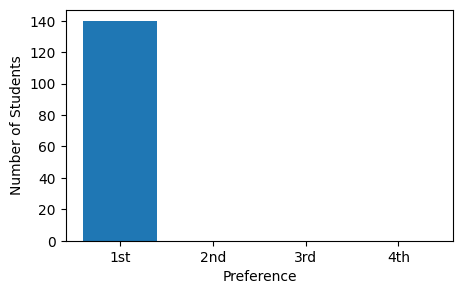

In [130]:
# Count the number of students assigned to each preference rank
preferences_count = [0, 0, 0, 0]
for i in range(n):
    for j in range(4):
        if x[i, P[i, j]].value > 0:
            preferences_count[j] += 1

# Plotting the bar graph
plt.figure(figsize=(5, 3))
plt.bar(['1st', '2nd', '3rd', '4th'], preferences_count)
plt.xlabel('Preference')
plt.ylabel('Number of Students')
plt.show()

#### Set Course Constraints

Since we are using smaller scale data, we can adjust the size of the course constraint to:
$$\sum_{s = 6}^{14} q_{j,s} = 1 \quad \forall j$$
There can be at most $Q_{13}$ course that can have a maximum size of 14:
$$\sum_j q_{j, 14} \leq Q_{13}$$ 
There can be at most $Q_{12}$ course that can have a maximum size of 13:
$$\sum_j q_{j, 13} \leq Q_{12}$$
There can be at most $Q_{6}$ course that can have a maximum size of 6:
$$\sum_j q_{j, 6} \leq Q_{6}$$

$$\sum_{i \in X_j} x_{i,j} = \sum_{s=6}^{14} sq_{j,s} \quad \forall j$$ 

In [131]:
# create set X_j, list of students for course j based on preference
Xj = []
# for each course
for j in range(m): 
    check_student = []
    # check if the student has a preferece of that course 
    for i in range(n):
        if j in P[i]:
            # if j is one the four choice of student i, add to list of student
            check_student.append(i)
    # for each j, add list of student
    Xj.append(check_student)
print(Xj)

[[5, 6, 7, 10, 12, 13, 19, 24, 25, 28, 29, 34, 35, 39, 41, 43, 47, 49, 51, 61, 83, 86, 91, 94, 101, 102, 103, 104, 105, 107, 108, 109, 110, 113, 115, 116, 128, 130], [0, 4, 5, 9, 12, 16, 17, 19, 23, 25, 26, 28, 32, 43, 44, 45, 52, 53, 54, 59, 60, 61, 62, 63, 65, 70, 71, 72, 75, 79, 80, 82, 85, 86, 89, 96, 100, 107, 117, 119, 121, 122, 124, 134, 138], [0, 3, 9, 19, 20, 21, 23, 24, 25, 26, 27, 31, 34, 35, 36, 37, 39, 41, 42, 51, 52, 55, 62, 63, 64, 66, 70, 73, 74, 76, 78, 79, 80, 84, 87, 88, 92, 103, 106, 109, 115, 118, 119, 120, 121, 127, 130, 133], [1, 5, 6, 10, 13, 16, 19, 22, 25, 30, 32, 33, 38, 40, 41, 43, 45, 52, 58, 61, 62, 64, 67, 69, 72, 81, 85, 88, 93, 95, 96, 98, 99, 101, 104, 108, 113, 114, 128, 132, 135, 136, 138], [3, 6, 11, 14, 18, 20, 23, 27, 30, 33, 34, 35, 38, 39, 40, 47, 49, 50, 54, 57, 58, 59, 61, 63, 66, 67, 68, 73, 76, 82, 83, 90, 91, 92, 94, 96, 98, 104, 109, 114, 117, 118, 121, 122, 123, 128, 129, 132, 134], [0, 3, 4, 5, 8, 16, 17, 18, 21, 31, 42, 47, 49, 51, 55, 

In [139]:
a = 2
x = cp.Variable((n, m), integer = True) # set a variable that can only have integer values
objective = cp.Minimize(cp.sum([cp.sum([x[i, P[i, 0]]  + a*x[i, P[i, 1]] + a**2*x[i,P[i, 2]] + a**3*x[i,P[i, 3]]for i in range(n)])]))

course_constraint = []

# each student gets exactly one course for j in preference of student i
for i in range(n):
    for j in range(m):
        course_constraint += [cp.sum([x[i, j] for j in P[i, :]]) == 1]
course_constraint += [x >= 0]

## new constraint

# create new variable q that indicates the size of c_j
q = cp.Variable((m, 9), integer = True)

for j in range(m):
#    course_constraint += [cp.sum(x[:, j]) >= 9] # lower bound 
#    course_constraint += [cp.sum(x[:, j]) <= 11] # upper bound
    course_constraint += [cp.sum(q[j, :]) == 1] 

course_constraint += [cp.sum(q[:, 0]) <= 5]
course_constraint += [cp.sum(q[:, 5]) <= 3]
course_constraint += [cp.sum(q[:, 6]) <= 4]
course_constraint += [cp.sum(q[:, 7]) <= 1]
course_constraint += [cp.sum(q[:, 8]) <= 9]

for j in range(m):
    assigned_students = cp.sum([x[i, j] for i in Xj[j]])
    max_students = cp.sum([s * q[j, s - 6] for s in range(6, 15)])
    course_constraint += [assigned_students == max_students]

prob = cp.Problem(objective, course_constraint)
prob.solve(verbose=True)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Apr 12 01:30:33 AM: Your problem has 1788 variables, 1710 constraints, and 0 parameters.
(CVXPY) Apr 12 01:30:33 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 12 01:30:33 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 12 01:30:33 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 12 01:30:33 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 12 01:30:34 AM: Compiling problem (target solver=SCIPY)

140.0

In [140]:
count = np.zeros(12)

for i in range(n):
    for j in range(m):
        if x[i, j].value == 1:
            count[j] += 1

print(count)

[11. 12. 12. 12. 10. 14. 13. 13. 15.  8. 12.  8.]


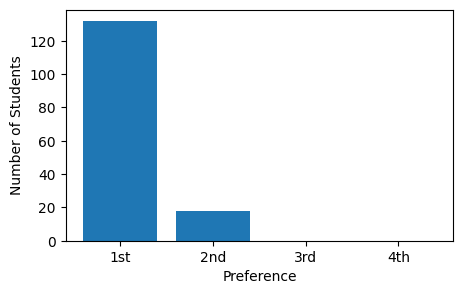

In [90]:
# Count the number of students assigned to each preference rank
preferences_count = np.zeros(4)
for i in range(n):
    for j in range(4):
        if x[i, P[i, j]].value == 1:
            preferences_count[j] += 1

# Plotting the bar graph
plt.figure(figsize=(5, 3))
plt.bar(['1st', '2nd', '3rd', '4th'], preferences_count)
plt.xlabel('Preference')
plt.ylabel('Number of Students')
plt.show()

Without the course constraint, there would be some students who will be placed to their second-ranked choice. Expanding the course size and allowing to be able to decrease the course size will minimize the dissatisfaction of students.

#### Set Gender Constraints

Plot graph for the demographics of students of each course

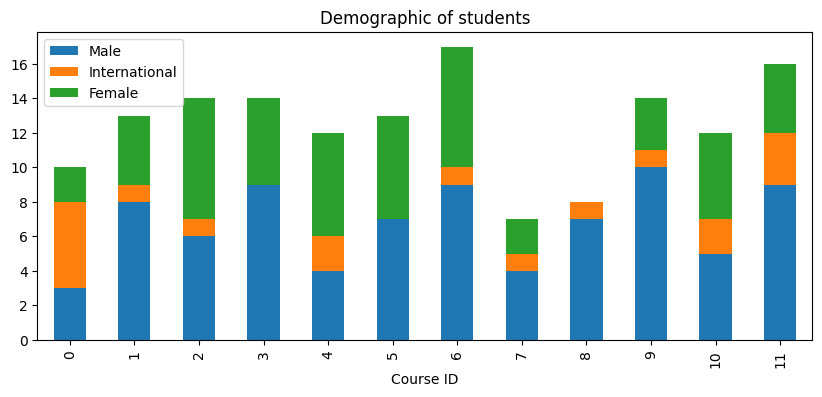

In [363]:
df = pd.DataFrame(0, index = np.arange(m), columns = ['Course ID', 'Male', 'International', 'Female'])

for j in range(m):
    for i in range(n):
        df.at[j, 'Course ID'] = j
        # if student i get assigned to course j
        if x[i, j].value == 1:
            # add to dataframe if student i is an international student
            if students[i][2] == 1:
                df.at[j, 'International'] += 1
            else:
                if students[i][1] == 1:
                    df.at[j, 'Female'] += 1
                else:
                    df.at[j, 'Male'] += 1
# plot stacked bar chart 

df.plot(x = 'Course ID', kind = 'bar', stacked = True, title = 'Demographic of students', figsize = (10, 4))
plt.show()

**Gender constraint**

There are at least 4 male and 4 female in each course

* $\sum_{i \in M \cap X_j} x_{i,j} \geq 4$
* $\sum_{i \in F \cap X_j} x_{i,j} \geq 4$

The same idea from the course size constraint can be used for the gender constraint to help loosened the constraint of having at least 4 male and female.

The paper introduced a new variable $y_{m,j} = 1$ when $C_j$ has a value of m males, and 0 otherwise. So, we can make sure that $C_j$ has a maximum of m number of males:
$$\sum_{m=0}^{17} y_{m,j} = 1 \quad \forall j$$
and thus, the total number of male students enrolled in $C_j$ can be equal to the maximum number of male students a course can have by multiplying m with $\sum_{m=0}^{17} y_{m,j}$:
$$\sum_{i \in M \cap X_j} x_{i,j} = \sum_{m=0}^{17} my_{m,j} \quad \forall j$$

Similarly, we will have the same formula for the number of females in a course:
$$\sum_{i \in F \cap X_j} x_{i,j} = \sum_{f=0}^{17} fy_{f,j} \quad \forall j$$

Since the scale is smaller, we will expect at least 2 male and 2 female in each course. 
* $\sum_{i \in M \cap X_j} x_{i,j} \geq 4$
* $\sum_{i \in F \cap X_j} x_{i,j} \geq 4$


$$\sum_{m=0}^{6} y_{m,j} = 1$$
$$\sum_{f=0}^{6} y_{f,j} = 1$$
$$\sum_{i \in M \cap X_j} x_{i,j} = \sum_{m=0}^{17} my_{m,j}$$
$$\sum_{i \in F \cap X_j} x_{i,j} = \sum_{f=0}^{17} fy_{f,j}$$

In [ ]:
gender_constraint = []
# create new variable y that indicates the 
m = range(6, 14)
q = cp.Variable((m, len(s)), integer = True)

In [ ]:
# create new variable q that indicates the size of c_j
s = range(6, 14)
q = cp.Variable((m, len(s)), integer = True)
constraint = []
course_constraint = []
q_constraint = [cp.sum(q[j, :]) == 1 for j in range(m)]
Q_constraint = [cp.sum(q[:, 0]) <= 1] 
Q_constraint1 = [cp.sum(q[:, 6]) <= 1] 
Q_constraint2 = [cp.sum(q[:, 7]) <= 1] 
course_constraint += q_constraint + Q_constraint + Q_constraint1 + Q_constraint2
course_constraint += [cp.sum([x[i, j] for i in Xj[j]]) == cp.sum([cp.multiply(s, q [j, s]) for s in range(2)]) for j in range(m)]
objective = cp.Minimize(cp.sum([cp.sum([x[i, P[i,0]]  + a*x[i, P[i,1]] + a**2*x[i,P[i,2]] + a**3*x[i,P[i,3]]for i in range(n)])]))

for i in range(n):
    for j in range(m):
        constraint += [cp.sum([x[i, j] for j in P[i, :]]) == 1]
constraint += [x >= 0]

constraint += course_constraint + gender_constraint

prob = cp.Problem(objective, constraint)
prob.solve(verbose=True)

#### Set international students constraints

$$\sum_{i \in I \cap X_j} x_{i,j} \leq 8$$

#### Create Functions

**Solve**